# <center> 👉 class_11_4 » _Face Swap_ </center>

## Face Swap Steps

https://pysource.com/2019/05/28/face-swapping-explained-in-8-steps-opencv-with-python/
https://github.com/spmallick/learnopencv/blob/master/FaceSwap/hillary_clinton.jpg.txt
    
1. Take two images

The “source image” is the one we take the face from and “destination image” is where we put the face extracted from the source image.    
<img src='./images/faceswap2.png'  width=800 height=400>
    
2. Find landmark points of both images    
<img src='./images/faceswap_mark.png'  width=800 height=400>  
Landmark points (dlib library)
We use the dlib library to detect the facial landmark points.  

>- './cv_data/shape_predictor_68_face_landmarks.dat'
>- https://github.com/davisking/dlib-models/blob/master/shape_predictor_68_face_landmarks.dat.bz2 

3. Triangulation source image (Delaunay triangulation)  
if we split the face into triangles, we can simply swap each triangle and in this way it will keep the proportions and also it will match the expressions of the new face, like for example if you smile, close eyes or open the mouth.
<img src='./images/faceswap2_tri.png'  width=800 height=400>  

### ※ Delaunay Triangles  

The Delaunay triangulation is the most efficient way to draw triangles between pairs of points.   
Each point is connected by lines to its closest neighbours, in such a way that all line parts form triangles, and do not intersect otherwise.   
No triangles overlap; in fact, the surface is completely covered with one nice layer of different triangular tiles.  

    들로네 삼각분할(Delaunay Triangulation)은 점 쌍 사이에 삼각형을 그리는 가장 효율적인 방법입니다.   
    각 점은 모든 선 부분이 삼각형을 형성하고 그렇지 않으면 교차하지 않는 방식으로 가장 가까운 이웃에 선으로 연결됩니다.   
    삼각형이 겹치지 않습니다. 사실, 표면은 서로 다른 삼각형 타일의 멋진 층으로 완전히 덮여 있습니다. 

    2차원 평면에 분포하는 점들을 대상으로 삼각형들을 만드는데 각각의 삼각형들은 본인들 세 점을 제외한 다른 점을 포함하지 않게끔 삼각형을 만들어 분할하는 것을 의미한다

<img src='./images/practice_img/Delaunay.png' align='left'  width=300 height=300>
<img src='./images/mesh_tri.png'  width=300 height=300> 

4. Triangulation destination image  
The triangulation of the destination image needs to have the same patterns of the triangulation of the source image.
That means that the connection of the points has to be the same.

So after we do the triangulation of the source image, from that triangulation we take the indexes of the landmark points so that we can replicate the same triangulation on the destination image.
<img src='./images/faceswap2_tri2.png'  width=800 height=400>  


5. Extract and warp triangles

<img src='./images/faceswap2_tri3.png'  width=800 height=400>  
Once we have the triangulation of both faces we take the triangles of the source face and we extract them.
We also need to take the coordinates of the triangles of the destination face, so that we can warp the triangles of the source face to have same size and perspective of the matchin triangle on the destination face.

6. Link the warped triangles together

<img src='./images/faceswap2_link.png'  width=800 height=400>  
We simply rebuild the face using the triangulation pattern, 


7. Replace the face on the destination image
<img src='./images/faceswap_r.png'  width=800 height=400>  
The face is now ready to be replaced. We cut out the face of the destination image to make space for the new face.  

8. Seamless Cloning 

<img src='./images/faceswap_r2.png'  width=800 height=400>  

In [3]:
import sys
import numpy as np
import cv2
import dlib

img = cv2.imread("./images/bradley_cooper.png")
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img2 = cv2.imread("./images/jim_carrey.png")
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# def faceLandmarker(im):   # We load Face detector and Face landmarks predictor

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./cv_data/shape_predictor_68_face_landmarks.dat")
# Face 1
faces = detector(img_gray)

with open("./images/bradley_cooper.png.txt", "w") as f:

    for face in faces:
        landmarks = predictor(img_gray, face)
        landmarks_points = []
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            landmarks_points.append((x, y))
    #     return landmarks_points
#         print(landmarks_points)
            print(x,y, file=f)

# Face 2
faces2 = detector(img2_gray)

with open("./images/jim_carrey.png.txt", "w") as f2:

    for face in faces2:
        landmarks2 = predictor(img2_gray, face)
        landmarks_points2 = []
        for n in range(0, 68):
            x2 = landmarks2.part(n).x
            y2 = landmarks2.part(n).y
            landmarks_points2.append((x2, y2))
            print(x2,y2, file=f2)



<img src='./images/faceswap_mark_ex.png' align='left'  width=300 height=300>
<img src='./images/faceswap_mark_ex2.png'  width=500 height=500>

In [4]:
#! /usr/bin/env python

import sys
import numpy as np
import cv2

def readPoints(path) :  # Read points from text file
    points = [];
    with open(path) as file :
        for line in file :
            x, y = line.split()
            points.append((int(x), int(y)))
    return points

# Apply affine transform calculated using srcTri and dstTri to src and output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri)) # Given a pair of triangles, find the affine transform.
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )
    return dst

def rectContains(rect, point) :   # Check if a point is inside a rectangle
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True

def calculateDelaunayTriangles(rect, points):  # calculate delanauy triangle
    
    subdiv = cv2.Subdiv2D(rect); # create subdiv
    for p in points:   # Insert points into subdiv
        subdiv.insert(p) 
    triangleList = subdiv.getTriangleList();
    delaunayTri = []
    pt = []    
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            for j in range(0, 3):    # Get face-points (from 68 face detector) by coordinates
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        pt = []        
    return delaunayTri

# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :
    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))

    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32) # Get mask by filling triangle
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]  # Apply warpImage to small rectangular patches
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    size = (r2[2], r2[3])
    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    img2Rect = img2Rect * mask
    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 
    
if __name__ == '__main__' :
#     (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

#     if int(major_ver) < 3 :
#         print >>sys.stderr, 'ERROR: Script needs OpenCV 3.0 or higher'
#         sys.exit(1)

    filename1 = './images/practice_img/ted_cruz.jpg'
    filename2 = './images/practice_img/donald_trump.jpg'
#     filename1 = "./images/practice_img/bradley_cooper.png"
#     filename2 = "./images/practice_img/jim_carrey.png"
    img1 = cv2.imread(filename1);
    img2 = cv2.imread(filename2);
    img1Warped = np.copy(img2);    
    
    # Read array of corresponding points
    points1 = readPoints(filename1 + '.txt')
    points2 = readPoints(filename2 + '.txt')    
    
    # Find convex hull
    hull1 = []
    hull2 = []
    hullIndex = cv2.convexHull(np.array(points2), returnPoints = False)
          
    for i in range(0, len(hullIndex)):
        hull1.append(points1[int(hullIndex[i])])
        hull2.append(points2[int(hullIndex[i])])
    
    # Find delanauy traingulation for convex hull points
    sizeImg2 = img2.shape    
    rect = (0, 0, sizeImg2[1], sizeImg2[0])
    dt = calculateDelaunayTriangles(rect, hull2)
    
    if len(dt) == 0:
        quit()
    
    # Apply affine transformation to Delaunay triangles
    for i in range(0, len(dt)):
        t1 = []
        t2 = []
        #get points for img1, img2 corresponding to the triangles
        for j in range(0, 3):
            t1.append(hull1[dt[i][j]])
            t2.append(hull2[dt[i][j]])
        warpTriangle(img1, img1Warped, t1, t2)
            
    # Calculate Mask
    hull8U = []
    for i in range(0, len(hull2)):
        hull8U.append((hull2[i][0], hull2[i][1]))
    mask = np.zeros(img2.shape, dtype = img2.dtype)  
    cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))
    r = cv2.boundingRect(np.float32([hull2]))    
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
    
    # Clone seamlessly.
    output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)
    
    cv2.imshow("Face Swapped", output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

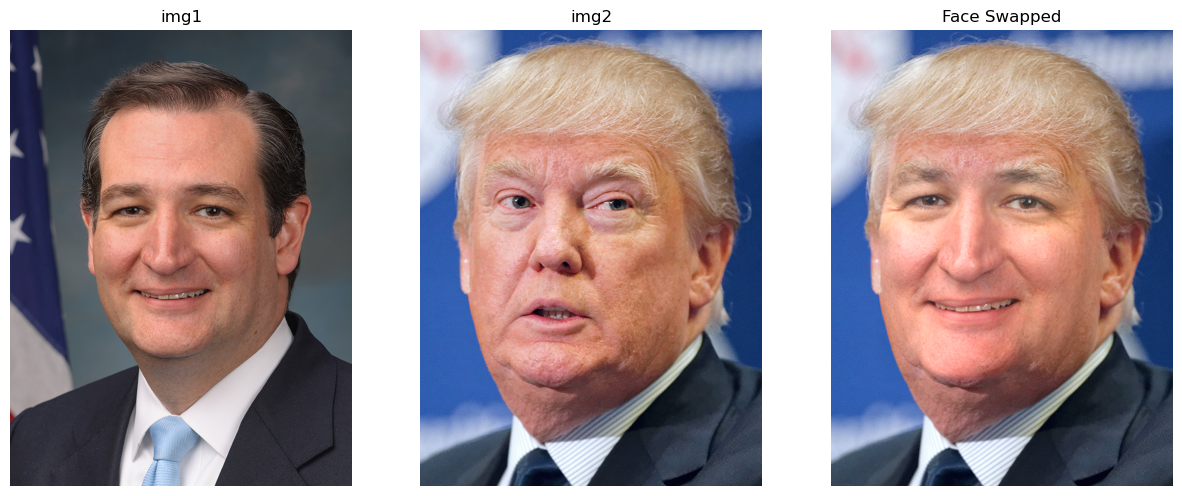

In [5]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=100)

plt.subplot(131),plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)),plt.title('img1'),plt.axis('off')
plt.subplot(132),plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)),plt.title('img2'),plt.axis('off')
plt.subplot(133),plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB)),plt.title('Face Swapped'),plt.axis('off')
plt.show()

In [15]:
#! /usr/bin/env python

import sys
import numpy as np
import cv2

def readPoints(path) :  # Read points from text file
    points = [];
    with open(path) as file :
        for line in file :
            x, y = line.split()
            points.append((int(x), int(y)))
    return points

# Apply affine transform calculated using srcTri and dstTri to src and output an image of size.
def applyAffineTransform(src, srcTri, dstTri, size) :
    warpMat = cv2.getAffineTransform(np.float32(srcTri), np.float32(dstTri)) # Given a pair of triangles, find the affine transform.
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )
    return dst

def rectContains(rect, point) :   # Check if a point is inside a rectangle
    if point[0] < rect[0] :
        return False
    elif point[1] < rect[1] :
        return False
    elif point[0] > rect[0] + rect[2] :
        return False
    elif point[1] > rect[1] + rect[3] :
        return False
    return True

def calculateDelaunayTriangles(rect, points):  # calculate delanauy triangle
    
    subdiv = cv2.Subdiv2D(rect); # create subdiv
    for p in points:   # Insert points into subdiv
        subdiv.insert(p) 
    triangleList = subdiv.getTriangleList();
    delaunayTri = []
    pt = []    
    for t in triangleList:        
        pt.append((t[0], t[1]))
        pt.append((t[2], t[3]))
        pt.append((t[4], t[5]))
        
        pt1 = (t[0], t[1])
        pt2 = (t[2], t[3])
        pt3 = (t[4], t[5])        
        
        if rectContains(rect, pt1) and rectContains(rect, pt2) and rectContains(rect, pt3):
            ind = []
            for j in range(0, 3):    # Get face-points (from 68 face detector) by coordinates
                for k in range(0, len(points)):                    
                    if(abs(pt[j][0] - points[k][0]) < 1.0 and abs(pt[j][1] - points[k][1]) < 1.0):
                        ind.append(k)    
            # Three points form a triangle. Triangle array corresponds to the file tri.txt in FaceMorph 
            if len(ind) == 3:                                                
                delaunayTri.append((ind[0], ind[1], ind[2]))
        pt = []        
    return delaunayTri

# Warps and alpha blends triangular regions from img1 and img2 to img
def warpTriangle(img1, img2, t1, t2) :
    # Find bounding rectangle for each triangle
    r1 = cv2.boundingRect(np.float32([t1]))
    r2 = cv2.boundingRect(np.float32([t2]))
    # Offset points by left top corner of the respective rectangles
    t1Rect = [] 
    t2Rect = []
    t2RectInt = []

    for i in range(0, 3):
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))
        t2RectInt.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))

    mask = np.zeros((r2[3], r2[2], 3), dtype = np.float32) # Get mask by filling triangle
    cv2.fillConvexPoly(mask, np.int32(t2RectInt), (1.0, 1.0, 1.0), 16, 0);
    img1Rect = img1[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]  # Apply warpImage to small rectangular patches
    #img2Rect = np.zeros((r2[3], r2[2]), dtype = img1Rect.dtype)
    size = (r2[2], r2[3])
    img2Rect = applyAffineTransform(img1Rect, t1Rect, t2Rect, size)
    img2Rect = img2Rect * mask
    # Copy triangular region of the rectangular patch to the output image
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] * ( (1.0, 1.0, 1.0) - mask )
    img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] = img2[r2[1]:r2[1]+r2[3], r2[0]:r2[0]+r2[2]] + img2Rect 
    
if __name__ == '__main__' :
#     (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')

#     if int(major_ver) < 3 :
#         print >>sys.stderr, 'ERROR: Script needs OpenCV 3.0 or higher'
#         sys.exit(1)

#     filename1 = './images/practice_img/ted_cruz.jpg'
#     filename2 = './images/practice_img/donald_trump.jpg'
    filename1 = "./images/bradley_cooper.png"
    filename2 = "./images/jim_carrey.png"
    img1 = cv2.imread(filename1);
    img2 = cv2.imread(filename2);
    img1Warped = np.copy(img2);    
    
    # Read array of corresponding points
    points1 = readPoints(filename1 + '.txt')
    points2 = readPoints(filename2 + '.txt')    
    
    # Find convex hull
    hull1 = []
    hull2 = []
    hullIndex = cv2.convexHull(np.array(points2), returnPoints = False)
          
    for i in range(0, len(hullIndex)):
        hull1.append(points1[int(hullIndex[i])])
        hull2.append(points2[int(hullIndex[i])])
    
    # Find delanauy traingulation for convex hull points
    sizeImg2 = img2.shape    
    rect = (0, 0, sizeImg2[1], sizeImg2[0])
    dt = calculateDelaunayTriangles(rect, hull2)
    
    if len(dt) == 0:
        quit()
    
    # Apply affine transformation to Delaunay triangles
    for i in range(0, len(dt)):
        t1 = []
        t2 = []
        #get points for img1, img2 corresponding to the triangles
        for j in range(0, 3):
            t1.append(hull1[dt[i][j]])
            t2.append(hull2[dt[i][j]])
        warpTriangle(img1, img1Warped, t1, t2)
            
    # Calculate Mask
    hull8U = []
    for i in range(0, len(hull2)):
        hull8U.append((hull2[i][0], hull2[i][1]))
    mask = np.zeros(img2.shape, dtype = img2.dtype)  
    cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))
    r = cv2.boundingRect(np.float32([hull2]))    
    center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
    
    # Clone seamlessly.
    output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)
    
    cv2.imshow("Face Swapped", output)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

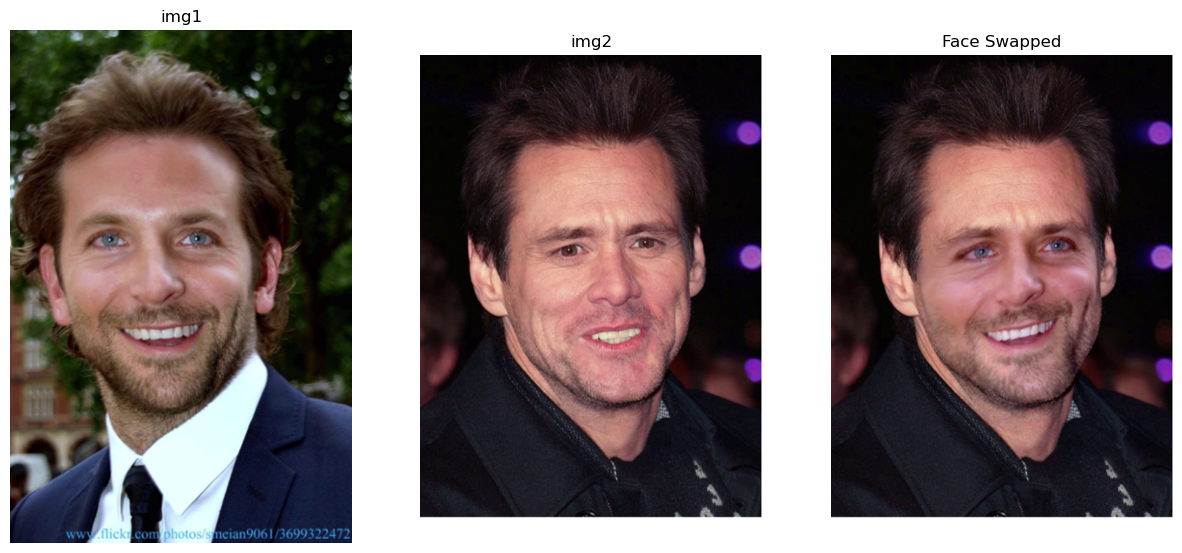

In [16]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=100)

plt.subplot(131),plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)),plt.title('img1'),plt.axis('off')
plt.subplot(132),plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)),plt.title('img2'),plt.axis('off')
plt.subplot(133),plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB)),plt.title('Face Swapped'),plt.axis('off')
plt.show()

In [17]:
import urllib.request as urlreq
import os
import matplotlib.pyplot as plt
from pylab import rcParams

# save picture's url in pics_url variable
pics_url = "https://www.bing.com/images/search?view=detailV2&ccid=Gwb8v9Ox&id=BFF09BF3680F87AA273AF5099392C666403C7443&thid=OIP.Gwb8v9OxDPuuPb1qNNRerwHaD4&mediaurl=https%3a%2f%2fapi.time.com%2fwp-content%2fuploads%2f2017%2f10%2fgettyimages-635098974.jpg%3fquality%3d85%26w%3d1200%26h%3d628%26crop%3d1&exph=628&expw=1200&q=Donald_Trump_Justin_Trudeau_2017-02-13&simid=608022929950076432&FORM=IRPRST&ck=251A120A264883ED4442C00D10D17427&selectedIndex=12&ajaxhist=0&ajaxserp=0"

# save picture's name as pic
pic = "image.jpg"

# chech if picture is in working directory
if (pic in os.listdir(os.curdir)):
    print("Picture exists")
else:
    # download picture from url and save locally as image.jpg
    urlreq.urlretrieve(pics_url, pic)
    print("Picture downloaded")

Picture downloaded


### ■ shape_predictor_81_face_landmarks.dat

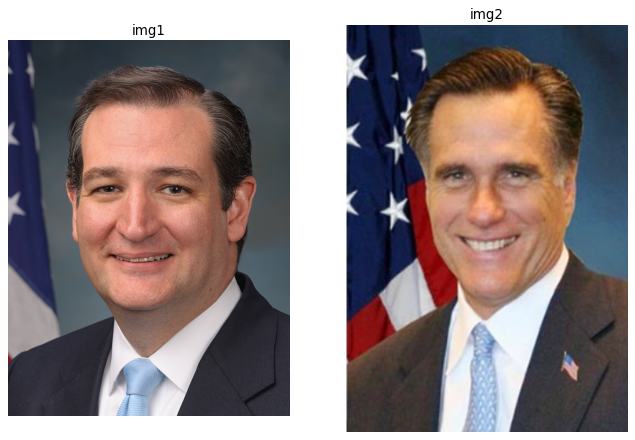

In [7]:
import sys
import numpy as np
import cv2
import dlib
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(10, 10), dpi=80)
img1 = cv2.imread("./images/ted_cruz.jpg")
img2 = cv2.imread("./images/romney.png")
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
# def faceLandmarker(im):   # We load Face detector and Face landmarks predictor
plt.subplot(121),plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)),plt.title('img1'),plt.axis('off')
plt.subplot(122),plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)),plt.title('img2'),plt.axis('off')
plt.show()

In [17]:
detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor("./cv_data/shape_predictor_68_face_landmarks.dat")
predictor_81 = dlib.shape_predictor("./cv_data/shape_predictor_81_face_landmarks.dat")

In [24]:
# predictor_81
img1 = cv2.imread("./images/ted_cruz.jpg")
img2 = cv2.imread("./images/romney.png")
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

faces1 = detector(img1_gray)
with open("./images/ted_cruz.jpg_81.txt", "w") as f81:

    for face in faces1:
        landmarks1 = predictor_81(img1_gray, face)
        landmarks_points1 = []
        for n in range(0, 81):
            x1 = landmarks1.part(n).x
            y1 = landmarks1.part(n).y
            landmarks_points1.append((x1, y1))
            print(x1,y1, file=f81)
            
    for landmark in landmarks_points1:
        img1_mk_81 = cv2.putText(img1, (str(landmark[0]) + ' ' + str(landmark[1])),\
                              landmark ,cv2.FONT_HERSHEY_SIMPLEX, 0.2, (255, 255, 255),1,cv2.LINE_AA)

faces2 = detector(img2_gray)
with open("./images/romney.png_81.txt", "w") as f81:
    for face in faces2:
        landmarks2 = predictor_81(img2_gray, face)
        landmarks_points2 = []
        for n in range(0, 81):
            x2 = landmarks2.part(n).x
            y2 = landmarks2.part(n).y
            landmarks_points2.append((x2, y2))
            print(x2,y2, file=f81)            
    for landmark in landmarks_points2:
        img2_mk_81 = cv2.putText(img2, (str(landmark[0]) + ' ' + str(landmark[1])),\
                              landmark ,cv2.FONT_HERSHEY_SIMPLEX, 0.1, (255, 255, 255),1,cv2.LINE_AA)            

In [25]:
filename1 = './images/ted_cruz.jpg'
filename2 = './images/romney.png'
img1 = cv2.imread(filename1)
img2 = cv2.imread(filename2)
img1Warped = np.copy(img2)    

# Read array of corresponding points
points1 = readPoints(filename1 + '_81.txt')
points2 = readPoints(filename2 + '_81.txt')    

# Find convex hull
hull1 = []
hull2 = []
hullIndex = cv2.convexHull(np.array(points2), returnPoints = False)

for i in range(0, len(hullIndex)):
    hull1.append(points1[int(hullIndex[i])])
    hull2.append(points2[int(hullIndex[i])])

# Find delanauy traingulation for convex hull points
sizeImg2 = img2.shape    
rect = (0, 0, sizeImg2[1], sizeImg2[0])
dt = calculateDelaunayTriangles(rect, hull2)

if len(dt) == 0:
    quit()

# Apply affine transformation to Delaunay triangles
for i in range(0, len(dt)):
    t1 = []
    t2 = []
    #get points for img1, img2 corresponding to the triangles
    for j in range(0, 3):
        t1.append(hull1[dt[i][j]])
        t2.append(hull2[dt[i][j]])
    warpTriangle(img1, img1Warped, t1, t2)

# Calculate Mask
hull8U = []
for i in range(0, len(hull2)):
    hull8U.append((hull2[i][0], hull2[i][1]))
mask = np.zeros(img2.shape, dtype = img2.dtype)  
cv2.fillConvexPoly(mask, np.int32(hull8U), (255, 255, 255))
r = cv2.boundingRect(np.float32([hull2]))    
center = ((r[0]+int(r[2]/2), r[1]+int(r[3]/2)))
output = cv2.seamlessClone(np.uint8(img1Warped), img2, mask, center, cv2.NORMAL_CLONE)

cv2.imshow("Face Swapped", output)
cv2.waitKey(0)
cv2.destroyAllWindows()

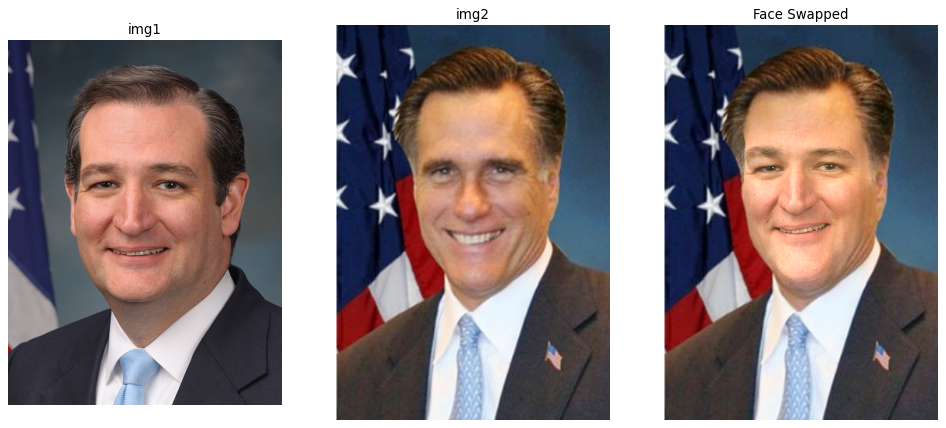

In [26]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=80)

plt.subplot(131),plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)),plt.title('img1'),plt.axis('off')
plt.subplot(132),plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)),plt.title('img2'),plt.axis('off')
plt.subplot(133),plt.imshow(cv2.cvtColor(output, cv2.COLOR_BGR2RGB)),plt.title('Face Swapped'),plt.axis('off')
plt.show()